# Camera Calibration with OpenCV
Karol Gutiérrez A01024536

## Calibrate Camera

This is one of the official patterns that OpenCV provides, the size of the pattern is given by the number of inner intersections. Then, the size of this grid is 6 x 9

![Pattern](images/pattern.png)

For the setup I took several photos at a distance of 1 meter from the pattern and I took several pictures at different positions

![Setup](images/setup.png)

Here we can see al the images that I took to calibrate the camera.

![AllImages](images/all.png)

### Python code for Camera Calibration
Source: https://www.learnopencv.com/camera-calibration-using-opencv/

In [1]:
# Load dependencies
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
%matplotlib inline

Processing image ./images/calibration/IMG_20200825_020515_1.jpg


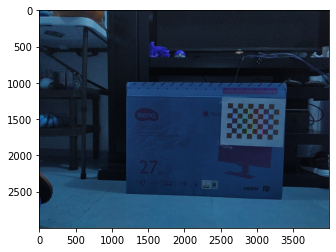

Processing image ./images/calibration/IMG_20200825_020214.jpg


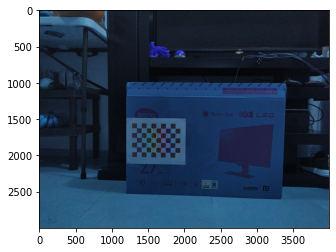

Processing image ./images/calibration/IMG_20200825_020429.jpg


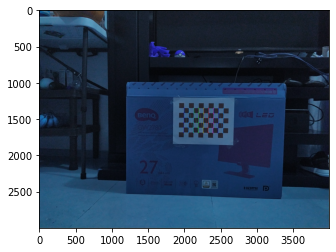

Processing image ./images/calibration/IMG_20200825_020139.jpg


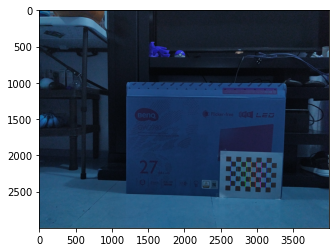

Processing image ./images/calibration/IMG_20200825_020104.jpg


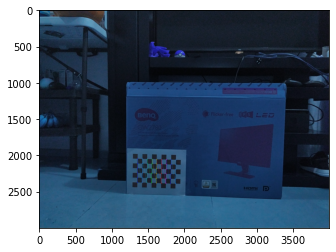

Processing image ./images/calibration/IMG_20200825_020517.jpg


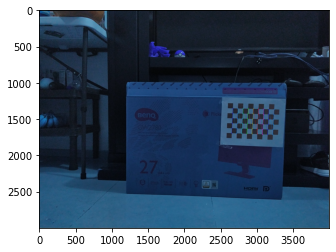

Processing image ./images/calibration/IMG_20200825_020337.jpg


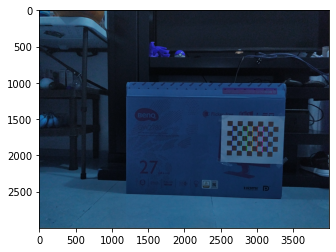

Processing image ./images/calibration/IMG_20200825_020251_1.jpg


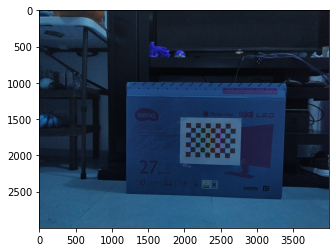

Processing image ./images/calibration/IMG_20200825_020406_1.jpg


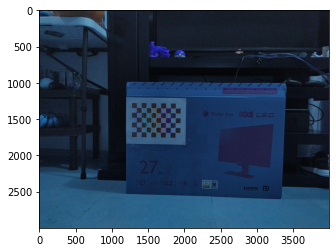

In [2]:
# Code to get images and intersection points

# Defining the dimensions of checkerboard
CHECKERBOARD = (6,9)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Creating vector to store vectors of 3D points for each checkerboard image
objpoints = []
# Creating vector to store vectors of 2D points for each checkerboard image
imgpoints = [] 


# Defining the world coordinates for 3D points
objp = np.zeros((1, CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)*23
prev_img_shape = None

# Extracting path of individual image stored in a given directory
images = glob.glob('./images/calibration/*.jpg')
for fname in images:
    print("Processing image " + fname)
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    # If desired number of corners are found in the image then ret = true
    ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)
    
    """
    If desired number of corner are detected,
    we refine the pixel coordinates and display 
    them on the images of checker board
    """
    if ret == True:
        objpoints.append(objp)
        # refining pixel coordinates for given 2d points.
        corners2 = cv2.cornerSubPix(gray, corners, (11,11),(-1,-1), criteria)
        
        imgpoints.append(corners2)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, CHECKERBOARD, corners2, ret)
    
    plt.imshow(img)
    plt.show()

In [3]:
# Getting calibration data

h,w = img.shape[:2]

"""
Performing camera calibration by 
passing the value of known 3D points (objpoints)
and corresponding pixel coordinates of the 
detected corners (imgpoints)
"""
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [4]:
print("Camera matrix : \n")
print(mtx)

Camera matrix : 

[[1.24851232e+04 0.00000000e+00 1.76446470e+03]
 [0.00000000e+00 1.26538068e+04 1.78303311e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


## What is the Focal Length of the Camera

We see from the camera matrix that fx and fy is approximately equal to 1.248e+04 but that is measured in pixels. looking at the camera specs we see that each pixel size is equal to 0.8e-06 m, then the focal distance would be (1.248e+04)* 0.8e-06 m = 0.0099 m = 9.9 mm.

But there is a problem with that because the camera does some image preprocessing. I found that the camera is 48MP but the actual image size is just 4000 x 3000 = 12MP. What the camera does is that it joins 4 pixels into 1, this is, two vertical pixels and two horizontal pixels are merged into one, then, the pixel size that we need to use in the formula is twice our current value, this is, 1.6e-06. Then, after replacing values we get that the actual focal lenght is 4.9 mm.

Another way to calculate this is by looking at the proportion of the sizes in the image. For example, the size of one square from the pattern in the real world is 23mm and in the image it is ~70px, and the distance from the camera to the sheet of paper is exactly 1m. Then, using the Magnification formula we get that the focal length must be 4.86mm.

After looking at the official camera specs, I saw that the focal length is 4.74 mm, which was close to my results.

## Take photos of a known object 1m away and, using the pin-hole model, calculate its dimensions, and compare them with the real ones.

![Object](images/object.jpg)

Here is an image of the object that I chose. It is a box and the pixel dimension is 696 x 433. Then, using the magnigication formula, given that the distance to the camera is exactly 1m and using the focal distance as 4.86 mm, we get that:

In [5]:
pixel_length = 1.6 * 10**-6
num_pixel_width = 696
num_pixel_height = 433
distance = 1
focal_length = 4.86 * 10**-3
world_width = num_pixel_width * pixel_length / focal_length
world_height = num_pixel_height * pixel_length / focal_length
print(f"Calculated width: {world_width}, calculated height: {world_height}." )

Calculated width: 0.22913580246913576, calculated height: 0.14255144032921807.


And the actual values are: 0.215m and 0.135m, which is closer to the dimensions using the pinhole model.

Then the error is the following

In [8]:
error_width = abs(world_width-0.215)/0.215
error_height = abs(world_height-0.135)/0.135
print("Error for width and height: " + str(error_width) + ", " + str(error_height))

Error for width and height: 0.06574791846109657, 0.0559365950312449


## Conclussions

One interesting observation is that the camera does some image processing when I take a photo. It is supossed to be a 48MP but at the end the image size is 4000x3000, which is equal to 12MP. Then, the equation to calculate the focal length needs to be adjusted in order to get a correct value. I think that this factor led to an error when I tried to calculate the size of the object.

## References

https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html


https://www.youtube.com/watch?v=HNfPbw-1e_w